# FIRIS/Firemap Data Assimilation



## Introduction

## Method

## Results

## Discussion

## Future Work

# Dependencies

In [1]:
# from kalmanutils import validate_geoms_matrix, interpolate_geometries
import farsiteutils_v2 as futils
import uuid
import datetime

import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, Point, GeometryCollection
from shapely.validation import make_valid

from matplotlib import pyplot as plt
import numpy as np

import random 
import pickle

import warnings
warnings.filterwarnings('ignore')

import requests
import arrow

import contextily as ctx

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Geometry handling - backend

In [2]:
def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0) 
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

## Geometry handling - public

In [3]:
def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))
    if len(interpolated_geom.exterior.coords[:-1]) == vertex_count-1:
        interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count+1))
    if len(interpolated_geom.exterior.coords[:-1]) == vertex_count+1:
        interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count-1))

    return interpolated_geom

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, rng, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = rng.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = rng.normal(mu, sigma)
        randy = rng.normal(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def sample_windspeed(loc, sigma, rng):
    ws = rng.normal(loc, sigma)
    if ws < 0:
        ws = 0
    return ws
def sample_winddirection(loc, sigma, rng):
    return np.fmod(rng.normal(loc, sigma)+360, 360)


def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A

## Plotting

In [4]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    if show_stdev:
        for vix in range(vcounts):
            print(f'Calculating {vix}/{vcounts}..    ', end='\r', flush=True)
            x,y = X[2*vix,:], X[2*vix+1,:]
            radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
            radstd[vix] = np.std(radius)
        print()
        for vix in range(vcounts):
            print(f'Drawing {vix}/{vcounts}..    ', end='\r', flush=True)
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

## Forward Pass

In [5]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User,
              lcpidx='43b7f5db36994599861eec4849cc68fd', 
              barrieridx='cb47616cd2dc4ccc8fd523bd3a5064bb'):

    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths('/home/jovyan/data/')
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                            (usr.db.dfsimulation['compareidx'] == observeidx)]
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]
    return Polygon(dfgeom.coords)

## Weather Station Data Collection

In [6]:
def collect_wx_data(gdfrow):

    ignite = gdfrow
    
    km_per_miles = 1.60934

    # ignite = gdfignition.to_crs(epsg=4326).loc[igniteidx]
    # compare = gdfignition.to_crs(epsg=4326).loc[compareidx]

    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = ignite['geometry'].centroid.x
    lat = ignite['geometry'].centroid.y
    
    radius = 20*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

    fromdt = ignite['datetime'].tz_localize('US/Pacific')
    # todt = compare['datetime'].tz_localize('US/Pacific')
    todt = fromdt + datetime.timedelta(minutes=30)
    
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    r_json = r.json()

    stations_lst = []
    for feature in r_json['features']:

        lon,lat = feature['geometry']['coordinates']

        name = feature['properties']['description']['name']
        wxid = feature['properties']['description']['id']
        provider = feature['properties']['description']['provider']
        wifire_uid = feature['properties']['description']['wifire_uid']

        timestamp = pd.to_datetime(feature['properties']['timestamp'])
        try:
            temperature = feature['properties']['temperature']
        except KeyError:
            temperature = []

        try:
            wind_speed = feature['properties']['wind_speed']
        except KeyError:
            wind_speed = []

        try:
            wind_direction = feature['properties']['wind_direction']
        except KeyError:
            wind_direction = []

        units = feature['properties']['units']

        stations_lst.append(Station(name, lat, lon, temperature, wind_speed, wind_direction, timestamp, units))
        
    return stations_lst

## EnKF Update

In [7]:
# def adjusted_perimeter_EnKF(initial_state, observation, aligned_geom, 
#                             X, N, rng, dt, nvertex, n_states):
#     """Returns the adjusted perimeter based on the observation and the FARSITE simulation through Ensemble Kalman Filter

#     Parameters:
#     -----------
#     initial_state : np.array
#         The initial polygon to run simulation with Farsite. Size of the array must match the (X.shape[0],1)
#     observation : dict
#         A collection of observations, including the observed fire perimeter, wind speed and wind direction, with
#         observation.keys() == ['geometry', 'windspeed', 'winddirection', 'wssigma', 'wdsigma', 'geomsigma'], and observation['geometry'] is a
#         shapely.Polygon object, 'windspeed' refers to an int value in mph, winddirection refers to an int value in 
#         range [0,360). The standard deviations 'wssigma', 'wdsigma', and 'geomsigma' are corresponding of their normal distributions
#     aligned_geom: shapely.Polygon
#         The geometry to align each polygon
#     uncertainties : int

#     X : np.array
#         Covariance matrix used in ensemble generation. The lower triangle of the Cholesky 
#         decomposition is used for fast calculation of the ensembles. Note that the lower triangle (L)
#         through the decomposition has the property X = LL* for hermitian positive-definite matrix X
#     N : int
#         The number of samples in the ensemble
#     rng : np.random.generator
#         The random number generator, used for sampling
#     dt : datetime.timedelta
#         The simulation time to calculate the FARSITE simulations.
#     nvertex : int
#         The fixed number of vertices for each state. n_states = 2*nvertex. Add two for windspeed and winddirection.
#     n_states : int
#         The number of states. n_states=2*nvertex.

#     Returns:
#     -----------
#     adjusted_state : np.array
#         The adjusted state for the next timepoint
#     X : np.array
#         The adjusted covariance matrix for the next timepoint
#     filled_count : int
#         Number of times the simulation didn't return a valid geometry
            
#     TODO:
#     -----------
#     - add landscape index to read from a table as an input. It only works for Maria fire at the moment.
#     - add multiprocessing to the ensemble calculation
#     - add uncertainties for each vertex of the observation.
#     - redefine the mapping of states to output. Ability to have n_states != n_output
#     - add more observations for additional parameter dependence
#     - add state variables in addition to the geometry vertices
#     - collect and return the windspeed and winddirection distributions
#     """

   
#     if initial_state.shape != (n_states, 1):
#         raise ValueError(f'initial_state has an incorrect shape: {initial_state.shape}')

#     if n_states != 2*nvertex:
#         raise ValueError(f'Only geometry vertices are added as state variables. More will be added later')
        
#     Xs = np.linalg.cholesky(X)

#     # The number of outputs is the number of variables of the observation.
#     # For now, this is set to the number of states
#     n_output = n_states
   

#     xkhat_ensemble = np.zeros((n_states, N))
#     wk_ensemble = np.zeros((n_states, N))
#     vk_ensemble = np.zeros((n_output, N))

#     zkphat_ensemble = np.zeros((n_states, N))
#     xkphat_ensemble = np.zeros((n_states, N))
#     ykhat_ensemble = np.zeros((n_output, N))

#     # Create N ensembles
#     sampled_wslst = []
#     sampled_wdlst = []
#     zkphat_geom_lst = []


#     # Calculate ensemble for each sample
#     for j in range(N):
#         print(f'Calculating {j}/{N}....', end='\r', flush=True)

#         # Generate a sample based on the covariance matrix received from the input
#         xkhat_ensemble[:,j:(j+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
        
#         ws = sample_windspeed(observation['windspeed'], observation['wssigma'], rng)
#         wd = sample_winddirection(observation['winddirection'], observation['wdsigma'], rng)
#         sampled_wslst.append(ws)
#         sampled_wdlst.append(wd)
        
#         zkphat_geom = forward_pass(state_to_geom(xkhat_ensemble[:,j:(j+1)]), params={'windspeed': ws,
#                                                                                       'winddirection': wd,
#                                                                                       'dt': dt})
        
#         if zkphat_geom is not None:
#             aligned_geom, zkphat_geom = align_geoms([aligned_geom, zkphat_geom], nvertex)
#             zkphat_geom_lst.append(zkphat_geom)
        
#         geom = state_to_geom(xkhat_ensemble[:,j:(j+1)])
#         geom = validate_geom(geom.simplify(geom_tolerance))
        
#         ykhat_geom = sample_geometry(geom, rng, observation['geomsigma'])
#         ykhat_ensemble[:,j:(j+1)] = geom_to_state(ykhat_geom, n_states, nvertex)


#     # If the FARSITE simulation is not done, then it fills in the ensemble
#     filled_count = N-len(zkphat_geom_lst)
#     if filled_count > 0:
#         zkphat_geom_lst = fill_null_geoms(zkphat_geom_lst, N)
#     for j in range(N):
#         zkphat_ensemble[:,j:(j+1)] = geom_to_state(zkphat_geom_lst[j], n_states, nvertex)

#     zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
#     ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)

#     # Calculate errors
#     # zkphat_ensemble -= zkphat_mean
#     # ykhat_ensemble -= ykhat_mean
#     for n in range(n_states):
#         zkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]

#     for n in range(n_output):
#         ykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]

#     Pzy = 1/N*np.matmul(zkphat_ensemble, ykhat_ensemble.T)
    
#     Py = 1/N*np.matmul(ykhat_ensemble, ykhat_ensemble.T)
#     Pyinv = np.linalg.pinv(Py)
#     # assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'
#     warnings.warn('Not checking the inverse calculation')

#     # Compute estimated Kalman gain based on correlations
#     L_EnKF = np.matmul(Pzy, Pyinv)

#     # compute mean valued state adjustmen using measurement y(k)
#     yk = geom_to_state(observation['geometry'], n_states, nvertex)
#     adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)

    
#     # Compute the state adjustment ensembles to update state covariance matrix X
    
#     for j in range(N):
#         xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])

#     xkphat_ensemble_copy = xkphat_ensemble.copy()

#     # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
#     xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
#     for n in range(n_states):
#         xkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
#     X = 1/N*np.matmul(xkphat_ensemble, xkphat_ensemble.T) + 1e-10*np.eye(n_states)
#     # Xs = np.linalg.cholesky(X)

#     return adjusted_state, X, filled_count, xkphat_ensemble_copy

In [8]:
# def update_EnKF(Xt, Y):
#     nsamples = Y.shape[1]

#     xt = Xt.mean(axis=1, keepdims=True)
#     y = Y.mean(axis=1, keepdims=True)

#     Ex = Xt - xt.repeat(nsamples, axis=1)
#     Ey = Y - y.repeat(nsamples, axis=1)

#     Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
#     Px = 1/(nsamples)*np.matmul(Ex, Ex.T)

#     Pxy_inv = np.linalg.pinv(Px + Py, hermitian=True)

#     assert(np.allclose(np.matmul(Pxy_inv, (Px+Py)), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

#     K = np.matmul(Px, Pxy_inv)

#     # Note that Xt has additional +2 in it
#     # Remove that with the matrix C
#     C = np.eye(Y.shape[0], Xt.shape[0])
#     #### Update the state ensemble
#     # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
#     X = Xt + np.matmul(K, (Y - Xt))

#     ### TODO ####
#     # Fix invalid geometries

#     # X = validate_geoms_matrix(X, aligned_geom)

#     return X, K

## Error Calculation

In [9]:
def calculate_rms(geom1, geom2, vertex_count=100):
    g1, g2 = align_geoms([geom1, geom2], vertex_count=vertex_count)
    xy1 = np.array(g1.exterior.coords[:-1])
    xy2 = np.array(g2.exterior.coords[:-1])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

## File I/O for data transfer through geojson

In [10]:
import geojson
def write_poly_as_geojson(poly, fpath):
    feature = geojson.Feature(geometry=poly)
    feature_collection = geojson.FeatureCollection([feature])
    with open(fpath, 'w') as f:
        geojson.dump(feature_collection, f)
        
def read_geojson_as_shapely(fpath):
    with open(fpath, 'r') as f:
        fcol = geojson.load(f)
    
    feature_geometry = fcol['features'][0]['geometry']
    return shapely.geometry.shape(feature_geometry)

In [11]:
def reproject_geom(geom, from_crs='EPSG:5070', to_crs='EPSG:3857'):
    return gpd.GeoSeries(geom, crs=from_crs).to_crs(to_crs)[0]

def get_wind_params(tix : int):
    wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
    wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

    return wslst[tix], wdlst[tix]

def get_observation(description : str, tix : int):
    ''' Obtain selected observation geometry and datetime
    '''

    if description not in ['Maria2019', 'River2021', 'Bridge2021']:
        raise ValueError(f'description {description} not present in db')
    
    def change_username_jovyan(df, column):
        for ix, row in df.iterrows():
            path_list = row[column].split('/')
            path_list[2] = 'jovyan'
    
            path = ''
            for string in path_list[:-1]:
                path += f'{string}/'
            path += path_list[-1]
    
            df.loc[ix, column] = path  
    
    df = pd.read_pickle('/home/jovyan/data/dftable_06032023.pkl')
    change_username_jovyan(df, 'filepath')
    
    dfrow = df[df['description'] == description].sort_values('datetime').iloc[tix]
    dfgeom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    dfdt = dfrow['datetime']
    
    return dfgeom, dfdt

def generate_forecast(initial_geom, params):
    geoms = [validate_geom(initial_geom)]
    for pix, param in enumerate(params):
        geoms.append(validate_geom(forward_pass(geoms[-1], params)))

    return geoms    

def plot_predictions(geoms, ax=None, color=(1,0,0)):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

    for gix, geom in enumerate(geoms):
        plot_geometry(reproject_geom(geom), ax=ax, color=color, alpha=((gix+1)/len(geoms)))

    ax.set_xlim((-13259490.671518039, -13248150.849562285))
    ax.set_ylim((4066608.972659642, 4075555.258855688))
    
    ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Obtain optimal windspeed, winddirection to calculate errors

In [12]:
geom0, timestamp0 = get_observation('Maria2019', 0)
geom1, timestamp1 = get_observation('Maria2019', 1)

dt = timestamp1 - timestamp0
dt

Timedelta('0 days 00:21:11')

## FARSITE at high wind speeds

In [14]:
# Calculate forward sim
wslst = range(15,100,5)
wd=60


geom_model_lst = []

for ws in wslst:
    print(f'Calculating {ws}/{wslst[-1]}..  ', end='\r', flush=True)
    params = {'windspeed': ws,
              'winddirection': wd,
              'dt': dt}
    
    geom_model = validate_geom(forward_pass(geom0, params))
    geom_model_lst.append(geom_model)

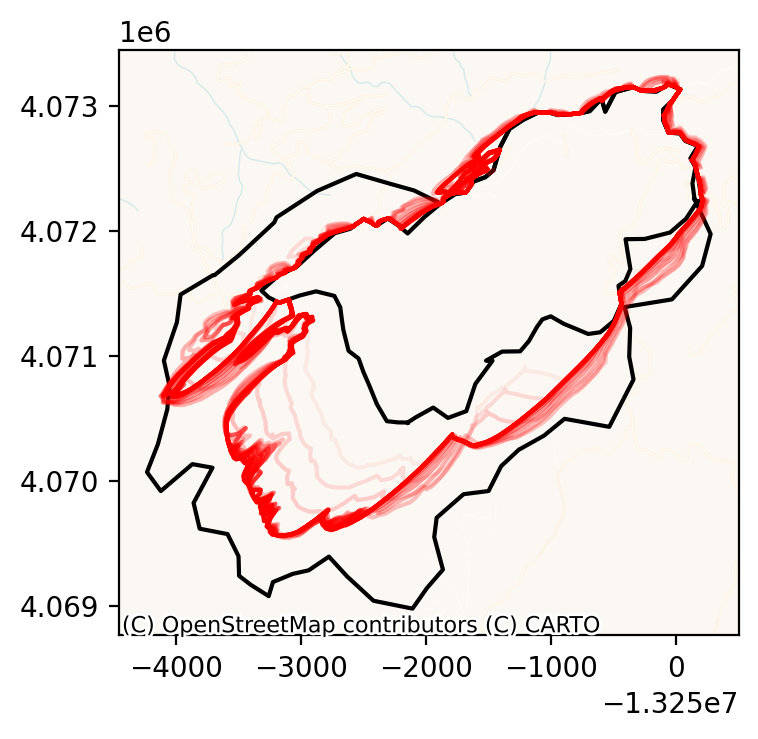

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# Initial fire perimeter
plot_geometry(reproject_geom(geom0), ax=ax, color=(0,0,0))
# Observed fire perimeter
plot_geometry(reproject_geom(geom1), ax=ax, color=(0,0,0))
# Calculated
for i in range(len(geom_model_lst)):
    geom = geom_model_lst[i]
    plot_geometry(reproject_geom(geom), ax=ax, color=(1,0,0), alpha=(i+1)/len(geom_model_lst))

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager)

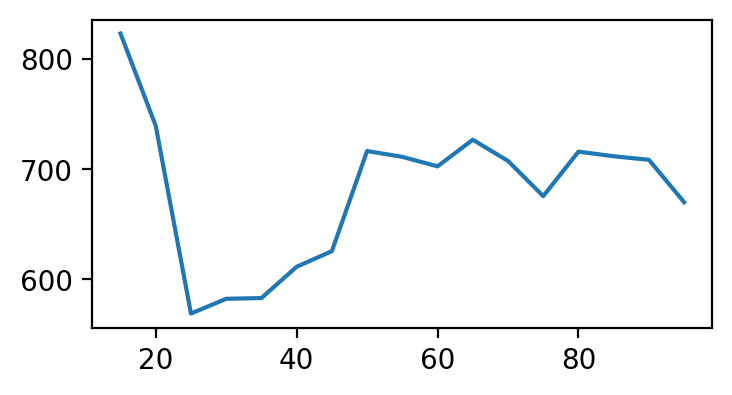

In [16]:
rms_error = []
area_error = []
for geom in geom_model_lst:
    rms_error.append(calculate_rms(geom1, geom, vertex_count=1000))
    area_error.append(calculate_area_diff(geom1, geom))

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(wslst, rms_error, label='RMS')

## Recalculating the EnKF

In [46]:
def geom_to_state(geom, nvertex):
    gv = geom_to_vector(interpolate_geom(geom, vertex_count=nvertex)).T
    return gv

def state_to_geom(state):
    return Polygon(zip(state[:-2:2,0], state[1:-2:2,0]))
    

n_vertex = 100
n_output = 2
n_states = 2*n_vertex + n_output

X = 10000*np.eye(n_states)
N = 100

Xs = np.linalg.cholesky(X)

ws = 25
wd = 60
wssigma = 5
wdsigma = 20

initial_geom, timestamp0 = get_observation('Maria2019', 0)
observed_geom, timestamp1 = get_observation('Maria2019', 1)
dt = timestamp1 - timestamp0

initial_state = geom_to_state(initial_geom, n_vertex)
initial_state = np.append(initial_state, [ws, wd]).reshape(1,n_states).T

observation = {'windspeed': ws, 'winddirection': wd,
               'wssigma': wssigma, 'wdsigma': wdsigma}
aligned_geom = initial_geom
rng = np.random.Generator(np.random.PCG64(1234))

xkhat_ensemble = np.zeros((n_states, N))   # current state
wk_ensemble = np.zeros((n_states, N))      # state noise variable
vk_ensemble = np.zeros((n_output, N))      # output noise

zkphat_ensemble = np.zeros((n_states, N))  # forward simulation, ws and wd is unchanged, same as in xkhat
xkphat_ensemble = np.zeros((n_states, N))  # adjusted forward simulation
ykhat_ensemble = np.zeros((n_output, N))   # output ensemble with noise std calculated from weather stations

# Create N ensembles
sampled_wslst = []
sampled_wdlst = []
zkphat_geom_lst = []


# Calculate ensemble for each sample
for j in range(N):
    print(f'Calculating {j}/{N}....', end='\r', flush=True)

    # Generate a sample based on the covariance matrix received from the input
    xkhat_ensemble[:,j:(j+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
    ws = sample_windspeed(observation['windspeed'], observation['wssigma'], rng)
    wd = sample_winddirection(observation['winddirection'], observation['wdsigma'], rng)
    sampled_wslst.append(ws)
    sampled_wdlst.append(wd)

    zkphat_geom = forward_pass(state_to_geom(xkhat_ensemble[:,j:(j+1)]), params={'windspeed': ws,
                                                                                  'winddirection': wd,
                                                                                  'dt': dt})
    ykhat_ensemble[:,j:(j+1)] = [[ws], [wd]]
    
    if zkphat_geom is not None:
        zkphat_geom = validate_geom(zkphat_geom)
        aligned_geom, zkphat_geom = align_geoms([aligned_geom, zkphat_geom], n_vertex)
        zkphat_geom_lst.append(zkphat_geom)
    
# If the FARSITE simulation is not done, then it fills in the ensemble
filled_count = N-len(zkphat_geom_lst)
if filled_count > 0:
    zkphat_geom_lst = fill_null_geoms(zkphat_geom_lst, N)
for j in range(N):
    zkphat_ensemble[:-2,j:(j+1)] = geom_to_state(zkphat_geom_lst[j], n_vertex)
    zkphat_ensemble[-2:,j:(j+1)] = ykhat_ensemble[:,j:(j+1)]

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)

Calculating 99/100..    


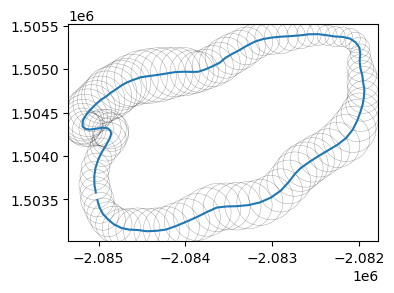

In [47]:
plot_matrix(zkphat_ensemble[:-2,:], show_stdev=True)

In [48]:
ezkphat_ensemble = np.zeros_like(zkphat_ensemble)
for n in range(n_states):
    ezkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]

eykhat_ensemble = np.zeros_like(ykhat_ensemble)
for n in range(n_output):
    eykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]

Pzy = 1/N*np.matmul(ezkphat_ensemble, eykhat_ensemble.T)

Py = 1/N*np.matmul(eykhat_ensemble, eykhat_ensemble.T)
Pyinv = np.linalg.pinv(Py)
assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'
# warnings.warn('Not checking the inverse calculation')

# Compute estimated Kalman gain based on correlations
L_EnKF = np.matmul(Pzy, Pyinv)

# compute mean valued state adjustmen using measurement y(k)
# yk = geom_to_state(observation['geometry'], n_states, nvertex)
yk = np.array([observation['windspeed'],
               observation['winddirection']]).reshape(ykhat_mean.shape)
adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)


# Compute the state adjustment ensembles to update state covariance matrix X

for j in range(N):
    xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])

# xkphat_ensemble_copy = xkphat_ensemble.copy()

# xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
exkphat_ensemble = np.zeros_like(xkphat_ensemble)
for n in range(n_states):
    exkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]

X = 1/N*np.matmul(exkphat_ensemble, exkphat_ensemble.T) + 1e-10*np.eye(n_states)

In [81]:
# Xs = np.linalg.cholesky(X)
# Xs

zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])

array([[-2.08540908e+06],
       [ 1.50379488e+06],
       [-2.08535495e+06],
       [ 1.50394062e+06],
       [-2.08528629e+06],
       [ 1.50411473e+06],
       [-2.08524321e+06],
       [ 1.50412434e+06],
       [-2.08509843e+06],
       [ 1.50401128e+06],
       [-2.08497267e+06],
       [ 1.50388417e+06],
       [-2.08499067e+06],
       [ 1.50395048e+06],
       [-2.08505234e+06],
       [ 1.50410236e+06],
       [-2.08507788e+06],
       [ 1.50426509e+06],
       [-2.08494355e+06],
       [ 1.50438531e+06],
       [-2.08512212e+06],
       [ 1.50440433e+06],
       [-2.08499717e+06],
       [ 1.50452270e+06],
       [-2.08502412e+06],
       [ 1.50456193e+06],
       [-2.08493214e+06],
       [ 1.50467182e+06],
       [-2.08489945e+06],
       [ 1.50477738e+06],
       [-2.08475842e+06],
       [ 1.50489759e+06],
       [-2.08468344e+06],
       [ 1.50490457e+06],
       [-2.08473007e+06],
       [ 1.50488737e+06],
       [-2.08457030e+06],
       [ 1.50489542e+06],
       [-2.0

Calculating 99/100..    


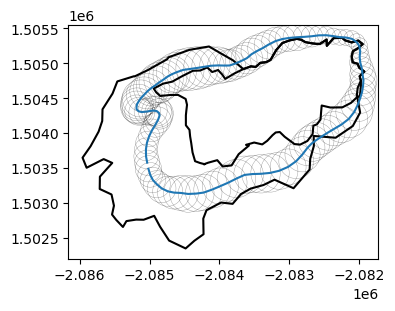

In [65]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
plot_geometry(geom0, ax=ax, color=(0,0,0))
plot_geometry(geom1, ax=ax, color=(0,0,0))
# plot_matrix_ensemble(xkphat_ensemble[:-2,:], ax=ax, color=(1,0,0,0.1), lw=1)
plot_matrix(xkphat_ensemble[:-2, :], ax=ax, show_stdev=True)
# xkphat_ensemble[-2:,:]
# display(validate_geom(state_to_geom(xkphat_mean)))
# display(state_to_geom(xkphat_mean))

In [ ]:
#######################################################

# Calculate errors
# zkphat_ensemble -= zkphat_mean
# ykhat_ensemble -= ykhat_mean
for n in range(n_states):
    zkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]

for n in range(n_output):
    ykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]

Pzy = 1/N*np.matmul(zkphat_ensemble, ykhat_ensemble.T)

Py = 1/N*np.matmul(ykhat_ensemble, ykhat_ensemble.T)
Pyinv = np.linalg.pinv(Py)
# assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'
warnings.warn('Not checking the inverse calculation')

# Compute estimated Kalman gain based on correlations
L_EnKF = np.matmul(Pzy, Pyinv)

# compute mean valued state adjustmen using measurement y(k)
yk = geom_to_state(observation['geometry'], n_states, nvertex)
adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)


# Compute the state adjustment ensembles to update state covariance matrix X

for j in range(N):
    xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])

xkphat_ensemble_copy = xkphat_ensemble.copy()

# xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
for n in range(n_states):
    xkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]

X = 1/N*np.matmul(xkphat_ensemble, xkphat_ensemble.T) + 1e-10*np.eye(n_states)
# Xs = np.linalg.cholesky(X)

return adjusted_state, X, filled_count, xkphat_ensemble_copy

In [ ]:
def adjusted_windspeed_winddir(initial_state, observation, aligned_geom, 
                            X, N, rng, dt, nvertex, n_states, n_output):
    """Returns the adjusted perimeter based on the observation and the FARSITE simulation through Ensemble Kalman Filter

    Parameters:
    -----------
    initial_state : np.array
        The initial polygon to run simulation with Farsite. Size of the array must match the (X.shape[0],1)
    observation : dict
        A collection of observations, including the observed fire perimeter, wind speed and wind direction, with
        observation.keys() == ['geometry', 'windspeed', 'winddirection', 'wssigma', 'wdsigma', 'geomsigma'], and observation['geometry'] is a
        shapely.Polygon object, 'windspeed' refers to an int value in mph, winddirection refers to an int value in 
        range [0,360). The standard deviations 'wssigma', 'wdsigma', and 'geomsigma' are corresponding of their normal distributions
    aligned_geom: shapely.Polygon
        The geometry to align each polygon
    uncertainties : int

    X : np.array
        Covariance matrix used in ensemble generation. The lower triangle of the Cholesky 
        decomposition is used for fast calculation of the ensembles. Note that the lower triangle (L)
        through the decomposition has the property X = LL* for hermitian positive-definite matrix X
    N : int
        The number of samples in the ensemble
    rng : np.random.generator
        The random number generator, used for sampling
    dt : datetime.timedelta
        The simulation time to calculate the FARSITE simulations.
    nvertex : int
        The fixed number of vertices for each state. n_states = 2*nvertex. Add two for windspeed and winddirection.
    n_states : int
        The number of states. n_states=2*nvertex.

    Returns:
    -----------
    adjusted_state : np.array
        The adjusted state for the next timepoint
    X : np.array
        The adjusted covariance matrix for the next timepoint
    filled_count : int
        Number of times the simulation didn't return a valid geometry
            
    TODO:
    -----------
    - add landscape index to read from a table as an input. It only works for Maria fire at the moment.
    - add multiprocessing to the ensemble calculation
    - add uncertainties for each vertex of the observation.
    - redefine the mapping of states to output. Ability to have n_states != n_output
    - add more observations for additional parameter dependence
    - add state variables in addition to the geometry vertices
    - collect and return the windspeed and winddirection distributions
    """

   
    if initial_state.shape != (n_states, 1):
        raise ValueError(f'initial_state has an incorrect shape: {initial_state.shape}')

    if n_states != 2*nvertex:
        raise ValueError(f'Only geometry vertices are added as state variables. More will be added later')
        
    Xs = np.linalg.cholesky(X)

    # The number of outputs is the number of variables of the observation.
    # For now, this is set to the number of states
    # n_output = n_states
    n_output = 2  # [wind_speed, wind_direction]
   

    xkhat_ensemble = np.zeros((n_states, N))
    wk_ensemble = np.zeros((n_states, N))
    vk_ensemble = np.zeros((n_output, N))

    zkphat_ensemble = np.zeros((n_states, N))
    xkphat_ensemble = np.zeros((n_states, N))
    ykhat_ensemble = np.zeros((n_output, N))

    # Create N ensembles
    sampled_wslst = []
    sampled_wdlst = []
    zkphat_geom_lst = []


    # Calculate ensemble for each sample
    for j in range(N):
        print(f'Calculating {j}/{N}....', end='\r', flush=True)

        # Generate a sample based on the covariance matrix received from the input
        xkhat_ensemble[:,j:(j+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
        
        ws = sample_windspeed(observation['windspeed'], observation['wssigma'], rng)
        wd = sample_winddirection(observation['winddirection'], observation['wdsigma'], rng)
        sampled_wslst.append(ws)
        sampled_wdlst.append(wd)
        
        zkphat_geom = forward_pass(state_to_geom(xkhat_ensemble[:,j:(j+1)]), params={'windspeed': ws,
                                                                                      'winddirection': wd,
                                                                                      'dt': dt})
        ykhat_ensemble[:,j:(j+1)] = [ws, wd]
        
        # if zkphat_geom is not None:
        #     aligned_geom, zkphat_geom = align_geoms([aligned_geom, zkphat_geom], nvertex)
        #     zkphat_geom_lst.append(zkphat_geom)
        
        # geom = state_to_geom(xkhat_ensemble[:,j:(j+1)])
        # geom = validate_geom(geom.simplify(geom_tolerance))
        
        # ykhat_geom = sample_geometry(geom, rng, observation['geomsigma'])
        # ykhat_ensemble[:,j:(j+1)] = geom_to_state(ykhat_geom, n_states, nvertex)

    # If the FARSITE simulation is not done, then it fills in the ensemble
    filled_count = N-len(zkphat_geom_lst)
    if filled_count > 0:
        zkphat_geom_lst = fill_null_geoms(zkphat_geom_lst, N)
    for j in range(N):
        zkphat_ensemble[:,j:(j+1)] = geom_to_state(zkphat_geom_lst[j], n_states, nvertex)

    zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)

    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    for n in range(n_states):
        zkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]

    for n in range(n_output):
        ykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]

    Pzy = 1/N*np.matmul(zkphat_ensemble, ykhat_ensemble.T)
    
    Py = 1/N*np.matmul(ykhat_ensemble, ykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)
    # assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'
    warnings.warn('Not checking the inverse calculation')

    # Compute estimated Kalman gain based on correlations
    L_EnKF = np.matmul(Pzy, Pyinv)

    # compute mean valued state adjustmen using measurement y(k)
    yk = geom_to_state(observation['geometry'], n_states, nvertex)
    adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)

    
    # Compute the state adjustment ensembles to update state covariance matrix X
    
    for j in range(N):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])

    xkphat_ensemble_copy = xkphat_ensemble.copy()

    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    for n in range(n_states):
        xkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/N*np.matmul(xkphat_ensemble, xkphat_ensemble.T) + 1e-10*np.eye(n_states)
    # Xs = np.linalg.cholesky(X)

    return adjusted_state, X, filled_count, xkphat_ensemble_copy

In [ ]:
plot_matrix_ensemble(xkphat_ensemble_lst[0])

In [ ]:
# Bridge 
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in range(5):
    geom, dt = get_observation('Bridge2021', i)
    plot_geometry(reproject_geom(geom), ax=ax, color=(1,0,0), alpha=(i+1)/5)

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager)

In [ ]:
get_observation('River2021', 4)

In [ ]:
#River
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in range(4):
    geom, dt = get_observation('River2021', i)
    plot_geometry(reproject_geom(geom), ax=ax, color=(1,0,0), alpha=(i+1)/4)

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager)

In [ ]:
#River
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in range(15):
    geom, dt = get_observation('Maria2019', i)
    plot_geometry(reproject_geom(geom), ax=ax, color=(1,0,0), alpha=(i+1)/15)

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager)

In [ ]:
geom = observation_geoms[0]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# plot_geometry(reproject_geom(state_to_geom(xkphat_mean).buffer(0), ), ax=ax, color='red')

plot_geometry(reproject_geom(observation_geoms[2]), ax=ax)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager)

In [ ]:
len(Polygon(interpolate_perimeter(geom1.exterior.coords[:-1], nvertex+1)).exterior.coords)

In [ ]:
geom1 = observation_geoms[0]
geom2 = zkphat_geom
# geom1 = zkphat_geom

In [ ]:
interpolated_geoms = interpolate_geoms([geom1, geom2], vertex_count=nvertex)
interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
for geom in interpolated_geoms[1:]:
    interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

interpolated_vertices = np.array(interpolated_vertices)
# align_vertices(np.array(interpolated_vertices))
# interpolated_vertices[0]

In [ ]:
len(interpolated_geoms[1].exterior.coords)

In [ ]:
minroll_lst = []

aligned_vertices = [interpolated_vertices[0]]
for i in range(len(interpolated_vertices)-1):
    right_vertices = interpolated_vertices[i+1]

    # Cycle right_vertices
    l2perroll = []
    for roll in range(len(interpolated_vertices[i])-1):
        diff = aligned_vertices[0] - right_vertices
        diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

        # Calculate diff^2 in
        l2perroll.append(diff2sum)

        right_vertices = np.roll(right_vertices,1, axis=0)

    minroll_lst.append(np.argmin(l2perroll))

In [ ]:
def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

In [ ]:
def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]


In [ ]:
# align_geoms([observation_geoms[0], zkphat_geom], nvertex)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(observation_geoms[0], ax=ax, color='blue')
plot_geometry(zkphat_geom, ax=ax, color='red')

In [ ]:
plot_matrix(xkhat_ensemble[:,j:(j+1)], color=(1,0,0,0.2), show_stdev=True)

# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# for k in range(j):
#     if k%5 == 0:
#         plot_geometry(state_to_geom(xkhat_ensemble[:,k:(k+1)]), ax=ax, color=(1,0,0,0.2))

In [ ]:
adjusted_geoms = []
for i in range(len(wslst)):
    geom = validate_geom(Polygon(zip(xkar_hat_EnKF[::2,i], xkar_hat_EnKF[1::2,i])))
    adjusted_geoms.append(geom)

adjusted_geoms[7]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in range(8,9):
    ax.plot(xkar_hat_EnKF[::2,i], xkar_hat_EnKF[1::2,i], color=(0,0,1), lw=1)
    plot_geometry(observation_geoms[i], color=(1,0,0), ls='-', lw=1, ax=ax)
    plot_geometry(ground_truth_geoms[i], color=(0,0,0), ls='--', lw=1, ax=ax)

ax.legend(['adjusted', 'observation', 'truth'])

### Previous calculation is here

In [ ]:
nsamples = 250
nvertex = 100

observation_geom_sigma = 250
observation_wd_sigma = wd_sigma
observation_ws_sigma = ws_sigma

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'nvertex': nvertex,
                       'observation_geom_sigma': observation_geom_sigma,
                       'observation_wd_sigma': observation_wd_sigma,
                       'observation_ws_sigma': observation_ws_sigma
                       },
       }


adjusted_geoms = [observation_geoms[0]]
for upix in range(1, len(observation_geoms)):
    print(f'Calculating {upix-1}-->{upix}')
    
    observed_geom = observation_geoms[upix]
    observed_wd = observation_wd[upix]
    observed_ws = observation_ws[upix]

    initial_poly = adjusted_geoms[upix-1]

    Xt_geoms = []
    Y_geoms = []
    sampled_wdlst = []
    sampled_wslst = []
    for s in range(nsamples):
        # Farsite Parameters for forward simulation
        ws = sample_windspeed(observed_ws, observation_ws_sigma, rng)
        sampled_wslst.append(ws)
        wd = sample_winddirection(observed_wd, observation_wd_sigma, rng)
        sampled_wdlst.append(wd)
        forward_geom = forward_pass(initial_poly, params = {'windspeed': ws,
                                                            'winddirection': wd,
                                                            'dt': datetime.timedelta(minutes=30)})
        if forward_geom is not None:
            Xt_geoms.append(forward_geom)

        # Sample observation
        Y_geoms.append(sample_geometry(observed_geom, rng, observation_geom_sigma))

    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)

    Y = geoms_to_matrix(Y_geoms, vertex_count=nvertex, nsamples=nsamples, aligned_geom=observation_geoms[0])
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=nvertex, nsamples=nsamples, aligned_geom=observation_geoms[0])
    X, K = update_EnKF(Xt, Y)

    Xmean = X.mean(axis=1)
    x,y = Xmean[::2], Xmean[1::2]
    adjusted_geoms.append(validate_geom(Polygon(zip(x,y))))
    
    data['calculations'].append({'initial_poly': initial_poly,
                             'aligned_geom': observation_geoms[0],
                             'filled_geoms': filled_count,
                              'Xt': Xt, 'X': X, 'Y': Y,
                              'wdar': sampled_wdlst, 'wsar': sampled_wslst})
    
    with open('/home/jovyan/data/output_reftest_09142023.pkl', 'wb') as f:
        pickle.dump(data, f)


### RMS Error comparison

In [ ]:
rms_error_obs = []
rms_error_fwd = []
rms_error_adj = []

area_error_obs = []
area_error_fwd = []
area_error_adj = []
for gix in range(len(adjusted_geoms)):
    geom_obs = observation_geoms[gix]
    geom_fwd = forward_from_ignition[gix]
    geom_adj = adjusted_geoms[gix]
    geom_tru = ground_truth_geoms[gix]

    rms_error_obs.append(calculate_rms(geom_obs, geom_tru, vertex_count=1000))
    rms_error_fwd.append(calculate_rms(geom_fwd, geom_tru, vertex_count=1000))
    rms_error_adj.append(calculate_rms(geom_adj, geom_tru, vertex_count=1000))

    area_error_obs.append(calculate_area_diff(geom_obs, geom_tru))
    area_error_fwd.append(calculate_area_diff(geom_fwd, geom_tru))
    area_error_adj.append(calculate_area_diff(geom_adj, geom_tru))


# Plot comparison
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(tlst[:len(adjusted_geoms)], rms_error_obs, label='observation', color='r')
ax.plot(tlst[:len(adjusted_geoms)], rms_error_fwd, label='forward', color='b')
ax.plot(tlst[:len(adjusted_geoms)], rms_error_adj, label='adjusted', color='k')

# ax.plot(tlst[:len(adjusted_geoms)], np.array(rms_error_fwd)-np.array(rms_error_obs), label='forward', color='b')
# ax.plot(tlst[:len(adjusted_geoms)], np.array(rms_error_adj)-np.array(rms_error_obs), label='adjusted', color='k')

ax.set_xlabel('Hours after ignition')
ax.set_ylabel('RMS Error')

# ax2 = ax.twinx()
# ax2.plot(tlst[:len(adjusted_geoms)], area_error_obs, color='r', ls='--')
# ax2.plot(tlst[:len(adjusted_geoms)], area_error_fwd, color='b', ls='--')
# ax2.plot(tlst[:len(adjusted_geoms)], area_error_adj, color='k', ls='--')
# ax2.set_ylabel('Area diff error')

ax.legend()


## Data assimilation through Maria fire Real observations

In [ ]:
# df = pd.read_pickle('/home/jovyan/data/dftable_06032023.pkl')
    
# def change_username_jovyan(df, column):
#     for ix, row in df.iterrows():
#         path_list = row[column].split('/')
#         path_list[2] = 'jovyan'

#         path = ''
#         for string in path_list[:-1]:
#             path += f'{string}/'
#         path += path_list[-1]

#         df.loc[ix, column] = path
# change_username_jovyan(df, 'filepath')

# dfrow = df[df['description'] == 'Maria2019'].sort_values('datetime').iloc[0]
# dfgeom = gpd.read_file(dfrow['filepath'])['geometry'][0]
# gpd.read_file(dfrow['filepath']).crs

In [ ]:
geom, dt = get_observation('Maria2019', 0)
geom1, dt1 = get_observation('Maria2019', 1)

cx = geom.centroid.xy[0][0] + 1000
cy = geom.centroid.xy[1][0] + 500
size = 100
ignition = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(geom), ax=ax)
plot_geometry(reproject_geom(ignition), ax=ax, color='red')
plot_geometry(reproject_geom(geom1), ax=ax, color='tab:blue')

ax.set_xlim((-13259490.671518039, -13248150.849562285))
ax.set_ylim((4066608.972659642, 4075555.258855688))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [ ]:
# Default values
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

params = {'windspeed': 15,
          'winddirection': 150,
          'dt': datetime.timedelta(minutes=30)}
geoms = generate_forecast(geom, params)

params1 = {'windspeed': 15,
          'winddirection': 10,
          'dt': datetime.timedelta(minutes=30)}
geoms1 = generate_forecast(geom, params1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_predictions(geoms[1:], ax=ax, color=(0,0,1))

plot_predictions(geoms1[1:], ax=ax, color=(1,0,0))

plot_geometry(reproject_geom(geom1), color=(0,0,0), ls='--', lw=1, ax=ax)

In [ ]:
geom, dt = get_observation('Maria2019', 0)
geom1, dt1 = get_observation('Maria2019', 1)

cx = geom.centroid.xy[0][0] + 1000
cy = geom.centroid.xy[1][0] + 500
size = 100
ignition = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(geom), ax=ax)
# plot_geometry(reproject_geom(geom_model), ax=ax, color='red')
plot_geometry(reproject_geom(geom1), ax=ax, color='red', ls='--')


ax.set_xlim((-13259490.671518039, -13248150.849562285))
ax.set_ylim((4066608.972659642, 4075555.258855688))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [ ]:
observation_geoms = []
timepoints = []

for tix in range(20):
    geom, tp = get_observation('Maria2019', tix)
    observation_geoms.append(geom)
    timepoints.append(tp)

In [ ]:
# Initial state is the first ignition (observation_geoms[0], observation_ws[0], observation_wd[0])
nvertex = 50
n_states = 2*nvertex
geom_tolerance = 100
geom_sigma = 100
ws_sigma = 3
wd_sigma = 50

initial_state = geom_to_state(observation_geoms[0], n_states, nvertex)


observation = {'geometry': observation_geoms[1],
               'windspeed': 40,
               'winddirection': 25,
               'wssigma': ws_sigma, 'wdsigma': wd_sigma, 'geomsigma': geom_sigma}
aligned_geom = observation_geoms[0]


X = 10*np.eye(2*nvertex)

N = 250
rng = np.random.Generator(np.random.PCG64(1234))
dt = datetime.timedelta(minutes=30)


adjusted_state, X, filled_counts, xkphat_ensemble = adjusted_perimeter_EnKF(initial_state, observation, aligned_geom,
                                                           X, N, rng, dt, nvertex, n_states)

In [ ]:
plot_matrix_ensemble(xkphat_ensemble)

In [ ]:
nvertex = 50
n_states = 2*nvertex
geom_tolerance = 100
geom_sigma = 100
ws_sigma = 3
wd_sigma = 50
X = 10*np.eye(2*nvertex)

N = 250

if initial_state.shape != (n_states, 1):
    raise ValueError(f'initial_state has an incorrect shape: {initial_state.shape}')

if n_states != 2*nvertex:
    raise ValueError(f'Only geometry vertices are added as state variables. More will be added later')
    
Xs = np.linalg.cholesky(X)

# The number of outputs is the number of variables of the observation.
# For now, this is set to the number of states
n_output = n_states


xkhat_ensemble = np.zeros((n_states, N))
wk_ensemble = np.zeros((n_states, N))
vk_ensemble = np.zeros((n_output, N))

zkphat_ensemble = np.zeros((n_states, N))
xkphat_ensemble = np.zeros((n_states, N))
ykhat_ensemble = np.zeros((n_output, N))

# Create N ensembles
sampled_wslst = []
sampled_wdlst = []
zkphat_geom_lst = []


# Calculate ensemble for each sample
for j in range(N):
    print(f'Calculating {j}/{N}....', end='\r', flush=True)

    # Generate a sample based on the covariance matrix received from the input
    xkhat_ensemble[:,j:(j+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
    ws = sample_windspeed(observation['windspeed'], observation['wssigma'], rng)
    wd = sample_winddirection(observation['winddirection'], observation['wdsigma'], rng)
    sampled_wslst.append(ws)
    sampled_wdlst.append(wd)
    
    zkphat_geom = forward_pass(state_to_geom(xkhat_ensemble[:,j:(j+1)]), params={'windspeed': ws,
                                                                                  'winddirection': wd,
                                                                                  'dt': dt})
    
    if zkphat_geom is not None:
        aligned_geom, zkphat_geom = align_geoms([aligned_geom, zkphat_geom], nvertex)
        zkphat_geom_lst.append(zkphat_geom)
    
    geom = state_to_geom(xkhat_ensemble[:,j:(j+1)])
    geom = validate_geom(geom.simplify(geom_tolerance))
    
    ykhat_geom = sample_geometry(geom, rng, observation['geomsigma'])
    ykhat_ensemble[:,j:(j+1)] = geom_to_state(ykhat_geom, n_states, nvertex)


# If the FARSITE simulation is not done, then it fills in the ensemble
filled_count = N-len(zkphat_geom_lst)
if filled_count > 0:
    zkphat_geom_lst = fill_null_geoms(zkphat_geom_lst, N)
for j in range(N):
    zkphat_ensemble[:,j:(j+1)] = geom_to_state(zkphat_geom_lst[j], n_states, nvertex)

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)

# Calculate errors
# zkphat_ensemble -= zkphat_mean
# ykhat_ensemble -= ykhat_mean
for n in range(n_states):
    zkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]

for n in range(n_output):
    ykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]

Pzy = 1/N*np.matmul(zkphat_ensemble, ykhat_ensemble.T)

Py = 1/N*np.matmul(ykhat_ensemble, ykhat_ensemble.T)
Pyinv = np.linalg.pinv(Py)
assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output), )), 'Inverse calculation is incorrect'

# Compute estimated Kalman gain based on correlations
L_EnKF = np.matmul(Pzy, Pyinv)

# compute mean valued state adjustmen using measurement y(k)
yk = geom_to_state(observation['geometry'], n_states, nvertex)
adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)


# Compute the state adjustment ensembles to update state covariance matrix X
for j in range(N):
    xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])

# xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
for n in range(n_states):
    xkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]

X = 1/N*np.matmul(xkphat_ensemble, xkphat_ensemble.T) + 1e-10*np.eye(n_states)
# Xs = np.linalg.cholesky(X)


In [ ]:
plot_matrix_ensemble(xkphat_ensemble[:,:2])